In [1]:
import sys 
from pathlib import Path

#Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt

from src.features import add_returns, add_mean_reversion_signal, add_momentum_signal, add_vol_regime
from src.data import fetch_yahoo
from src.backtest import backtest_from_signal
from src.metrics import summary

In [2]:
symbol = "SPY"
start, end = "2016-01-01", "2026-01-01"

df = fetch_yahoo(symbol, start, end)
df.head(), df.tail(), df.isna().sum()


(                  Open        High         Low       Close     Volume
 Date                                                                 
 2016-01-04  169.923028  170.380694  168.312697  170.372223  222353500
 2016-01-05  170.694250  171.118020  169.550081  170.660355  110845800
 2016-01-06  168.100771  169.558538  167.473601  168.507599  152112600
 2016-01-07  165.549692  167.337999  164.074970  164.464844  213436100
 2016-01-08  165.431046  165.990425  162.371432  162.659592  209817200,
                   Open        High         Low       Close    Volume
 Date                                                                
 2025-12-24  687.950012  690.830017  687.799988  690.380005  39445600
 2025-12-26  690.640015  691.659973  689.270020  690.309998  41613300
 2025-12-29  687.539978  689.200012  686.070007  687.849976  62559500
 2025-12-30  687.450012  688.559998  686.580017  687.010010  47160700
 2025-12-31  687.140015  687.359985  681.710022  681.919983  74144800,
 Open      

MOM:  {'sharpe': -0.8823936728824134, 'max_drawdown': -0.8587607839051613, 'AnnRet(approx)': -0.15867989738197885, 'AvgTurnover': 0.7052505966587113}
MR:  {'sharpe': -0.22227767453266034, 'max_drawdown': -0.5917505874501189, 'AnnRet(approx)': -0.05432803416136889, 'AvgTurnover': 0.1913285600636436}
MOM regime: {'regime=0': {'sharpe': -1.240604800700344, 'max_drawdown': -0.8580605758825384, 'AnnRet(approx)': -0.20997444238244434, 'AvgTurnover': 0.6538252848616386}, 'regime=1': {'sharpe': -0.6801869911030148, 'max_drawdown': -0.8065495587361762, 'AnnRet(approx)': -0.48125470031998785, 'AvgTurnover': 0.8477611940298507}}
MR  regime: {'regime=0': {'sharpe': -0.6783273854643559, 'max_drawdown': -0.5846685700966773, 'AnnRet(approx)': -0.0733662503831547, 'AvgTurnover': 0.17525773195876287}, 'regime=1': {'sharpe': 0.24639143943068895, 'max_drawdown': -0.5747948919869592, 'AnnRet(approx)': -0.19696133458253617, 'AvgTurnover': 0.23582089552238805}}


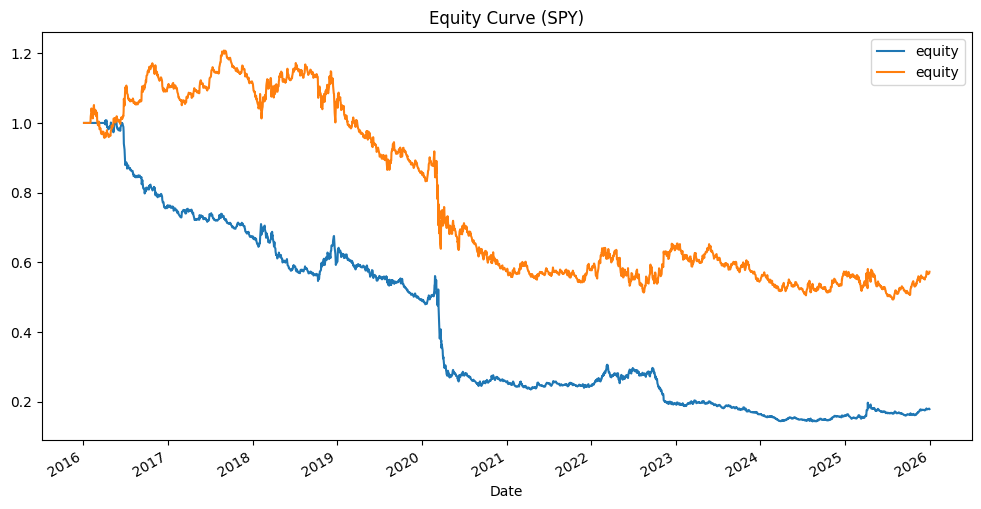

In [3]:
def regime_summary(bt, regime_col="high_vol"):
    out = {}
    for k, sub in bt.dropna(subset=["strat_ret"]).groupby(regime_col):
        out[f"regime={k}"] = summary(sub)
    return out


df = fetch_yahoo("SPY", "2016-01-01", "2026-01-01")
df = add_returns(df)
df = add_momentum_signal(df, lookback=60)
df = add_mean_reversion_signal(df, z_window=20)
df = add_vol_regime(df, vol_window=20, q=0.7)

bt_mom = backtest_from_signal(df, "signal_mom", fee_bps=1.0)
bt_mr = backtest_from_signal(df, "signal_mr", fee_bps=1.0)


print("MOM: ", summary(bt_mom))
print("MR: ", summary(bt_mr))
print("MOM regime:", regime_summary(bt_mom))
print("MR  regime:", regime_summary(bt_mr))


plt.figure(figsize=(12, 6))
bt_mom["equity"].plot()
bt_mr["equity"].plot()
plt.legend()
plt.title("Equity Curve (SPY)")
plt.show()
